In [9]:
import pandas as pd
import numpy as np
import boto3
import sagemaker
from sklearn.pipeline import make_pipeline, Pipeline
from skopt.space import Integer, Real
from skopt import BayesSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [3]:
## get training and testing data from teh s3 bucket
x_train_file_path = 's3://ads508-20240325131610-mi4zt/training_data/X_train_smote.csv'
y_train_file_path = 's3://ads508-20240325131610-mi4zt/training_data/y_train_smote.csv'
x_test_file_path = 's3://ads508-20240325131610-mi4zt/training_data/X_test.csv'
y_test_file_path = 's3://ads508-20240325131610-mi4zt/training_data/y_test.csv'
X_train = pd.read_csv(x_train_file_path)
y_train = pd.read_csv(y_train_file_path)
X_test = pd.read_csv(x_test_file_path)
y_test = pd.read_csv(y_test_file_path)

In [7]:
y_train['churn'].value_counts()

1    79855
0    79855
Name: churn, dtype: int64

In [8]:
y_test['churn'].value_counts()

1    34214
0     1281
Name: churn, dtype: int64

In [4]:
X_train

,price,freight_value,payment_installments,payment_value,review_score,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,order_status_canceled,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,23.800000,12.480000,1,36.280000,5,1.000000,283.0,24.000000,23.000000,20.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000
1,200.000000,84.590000,10,554.490000,1,2.000000,9650.0,40.000000,40.000000,40.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000
2,32.990000,16.110000,3,147.300000,5,1.000000,950.0,20.000000,35.000000,20.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000
3,39.900000,15.230000,1,55.130000,5,3.000000,150.0,20.000000,25.000000,25.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000
4,399.990000,43.780000,1,443.770000,4,1.000000,2650.0,39.000000,17.000000,39.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159705,30.851510,15.528691,6,92.252373,5,1.000000,850.0,25.105833,19.894167,17.702375,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.744708,0.0,0.255292
159706,175.500000,16.402207,10,767.608828,5,1.000000,867.0,34.000000,15.000000,15.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000
159707,49.620773,14.538714,1,64.159487,3,1.000000,600.0,17.837680,15.883094,15.883094,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000
159708,89.876402,15.183354,1,105.059757,3,2.078658,200.0,16.000000,5.895122,12.947561,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000


In [5]:
## Data needs to be scaled
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using r

Best parameters found:  OrderedDict([('max_depth', 12), ('max_features', 3), ('max_leaf_nodes', 16), ('min_impurity_decrease', 0.0001), ('min_samples_leaf', 4), ('min_samples_split', 4), ('n_estimators', 100)])
Best score achieved:  0.7632145764197608


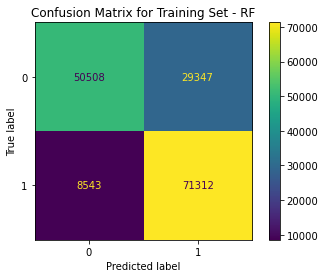

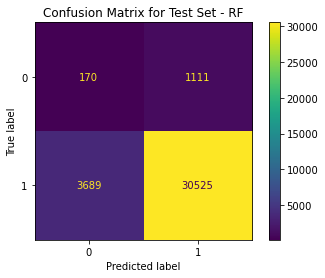

Classification Report for Training Set - RF:
              precision    recall  f1-score   support

           0       0.86      0.63      0.73     79855
           1       0.71      0.89      0.79     79855

    accuracy                           0.76    159710
   macro avg       0.78      0.76      0.76    159710
weighted avg       0.78      0.76      0.76    159710


Classification Report for Test Set - RF:
              precision    recall  f1-score   support

           0       0.04      0.13      0.07      1281
           1       0.96      0.89      0.93     34214

    accuracy                           0.86     35495
   macro avg       0.50      0.51      0.50     35495
weighted avg       0.93      0.86      0.90     35495



In [6]:
# Define the parameter space for Bayesian optimization
search_spaces = {
    'n_estimators': Integer(50, 100),  # Range between 25 and 75
    'max_depth': Integer(6, 12),  # Range between 2 and 4
    'min_samples_split': Integer(2, 4),  # Range between 2 and 3
    'min_samples_leaf': Integer(1, 4),  # Range between 5 and 10
    'max_features':  Integer(1, 5), # Range between 1 and 5
    'max_leaf_nodes': Integer(8, 16),  # Range between 3 and 5
    'min_impurity_decrease': Real(0.0001, 0.01, "log-uniform"),  # Log-uniform distribution between 0.0001 and 0.01
}

rf = RandomForestClassifier(random_state=42)
# Set up the BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=rf,
    search_spaces=search_spaces,
    n_iter=50,  # Reduced for quicker execution, adjust as needed
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Perform the hyperparameter search
bayes_search.fit(X_train_scaled, y_train)

# Best parameters and score
print("Best parameters found: ", bayes_search.best_params_)
print("Best score achieved: ", bayes_search.best_score_)
# Make predictions on both training and testing sets using the best model
y_pred_train = bayes_search.predict(X_train_scaled)
y_pred_test = bayes_search.predict(X_test_scaled)

# Generate and display confusion matrices
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

labels = bayes_search.best_estimator_.classes_
cmplot_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
cmplot_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)

cmplot_train.plot()
plt.title('Confusion Matrix for Training Set - RF')
plt.show()

cmplot_test.plot()
plt.title('Confusion Matrix for Test Set - RF')
plt.show()

# Generate classification reports
train_report = classification_report(y_train, y_pred_train)
test_report = classification_report(y_test, y_pred_test)

print("Classification Report for Training Set - RF:")
print(train_report)
print("\nClassification Report for Test Set - RF:")
print(test_report)

[LightGBM] [Info] Number of positive: 63884, number of negative: 63884
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3791
[LightGBM] [Info] Number of data points in the train set: 127768, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

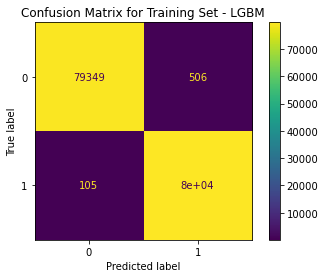

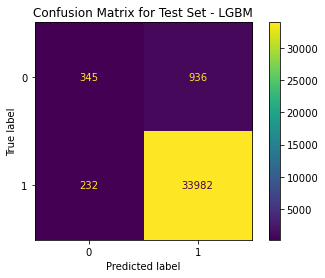

Classification Report for Training Set - LGBM:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     79855
           1       0.99      1.00      1.00     79855

    accuracy                           1.00    159710
   macro avg       1.00      1.00      1.00    159710
weighted avg       1.00      1.00      1.00    159710


Classification Report for Test Set - LGBM:
              precision    recall  f1-score   support

           0       0.60      0.27      0.37      1281
           1       0.97      0.99      0.98     34214

    accuracy                           0.97     35495
   macro avg       0.79      0.63      0.68     35495
weighted avg       0.96      0.97      0.96     35495



In [12]:


# Define the parameter space for Bayesian optimization
search_spaces = {
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(100, 1000),
    'num_leaves': Integer(20, 40),
    'max_depth': Integer(3, 10),
    'min_child_samples': Integer(100, 500),
    'subsample': Real(0.5, 1.0)
}
# Initialize the LightGBM classifier
lgbm = lgb.LGBMClassifier(random_state=42)

# Set up the BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=lgbm,
    search_spaces=search_spaces,
    n_iter=10,  # Reduced for quicker execution, adjust as needed
    cv=5,
    n_jobs=-1,
    random_state=42
)
y_train = y_train['churn'].ravel()
# Perform the hyperparameter search
bayes_search.fit(X_train_scaled, y_train)


# Best parameters and score
print("Best parameters found: ", bayes_search.best_params_)
print("Best score achieved: ", bayes_search.best_score_)
# Make predictions on both training and testing sets using the best model
y_pred_train = bayes_search.predict(X_train_scaled)
y_pred_test = bayes_search.predict(X_test_scaled)

# Generate and display confusion matrices
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

labels = bayes_search.best_estimator_.classes_
cmplot_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
cmplot_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)

cmplot_train.plot()
plt.title('Confusion Matrix for Training Set - LGBM')
plt.show()

cmplot_test.plot()
plt.title('Confusion Matrix for Test Set - LGBM')
plt.show()

# Generate classification reports
train_report = classification_report(y_train, y_pred_train)
test_report = classification_report(y_test, y_pred_test)

print("Classification Report for Training Set - LGBM:")
print(train_report)
print("\nClassification Report for Test Set - LGBM:")
print(test_report)

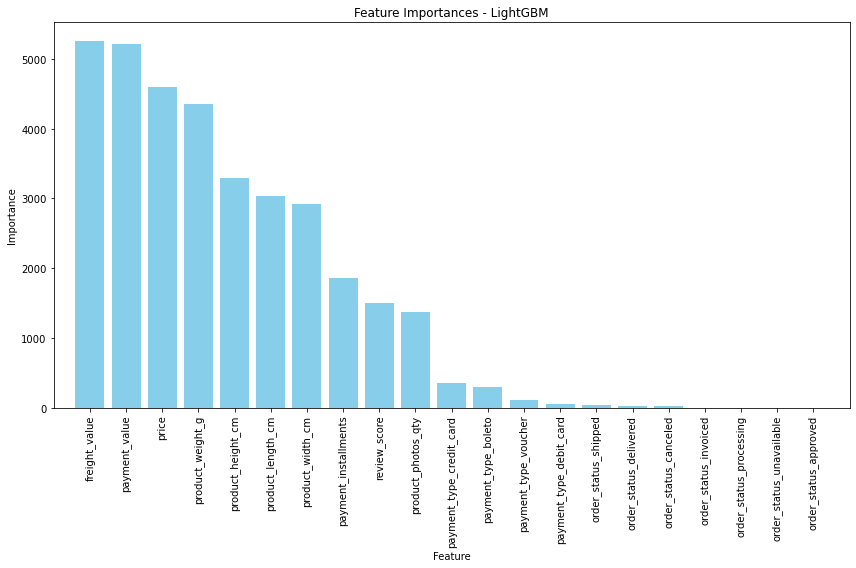

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3702
[LightGBM] [Info] Number of data points in the train set: 127768, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [14]:
# Get feature importances from the best LightGBM model
best_lgbm = bayes_search.best_estimator_
importances = best_lgbm.feature_importances_
feature_names = X_train.columns
# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances - LightGBM")
plt.bar(range(X_train.shape[1]), importances[indices],
        align="center", color='skyblue')
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [38]:
X_train['Volumn'] = X_train['product_length_cm'] * X_train['product_height_cm'] * X_train['product_width_cm']
X_test['Volumn'] = X_test['product_length_cm'] * X_test['product_height_cm'] * X_test['product_width_cm']
X_train_new = X_train.drop(columns = ['freight_value', 'payment_value', 'product_length_cm', 'product_height_cm', 'product_width_cm'])
X_test_new = X_test.drop(columns = ['freight_value', 'payment_value', 'product_length_cm', 'product_height_cm', 'product_width_cm'])

In [39]:
X_train_new

,price,payment_installments,review_score,product_photos_qty,product_weight_g,order_status_approved,order_status_canceled,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,Volumn
0,23.800000,1,5,1.000000,283.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,11040.000000
1,200.000000,10,1,2.000000,9650.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,64000.000000
2,32.990000,3,5,1.000000,950.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,14000.000000
3,39.900000,1,5,3.000000,150.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,12500.000000
4,399.990000,1,4,1.000000,2650.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,25857.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159705,30.851510,6,5,1.000000,850.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.744708,0.0,0.255292,8841.621740
159706,175.500000,10,5,1.000000,867.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,7650.000000
159707,49.620773,1,3,1.000000,600.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,4499.958990
159708,89.876402,1,3,2.078658,200.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,1221.239275


In [40]:
## Data needs to be scaled
scaler_new = StandardScaler()
scaler_new.fit(X_train_new)
X_train_scaled_new = scaler_new.transform(X_train_new)
X_test_scaled_new = scaler_new.transform(X_test_new)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

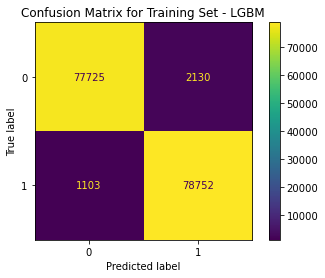

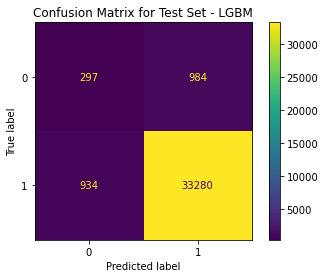

Classification Report for Training Set - LGBM:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     79855
           1       0.97      0.99      0.98     79855

    accuracy                           0.98    159710
   macro avg       0.98      0.98      0.98    159710
weighted avg       0.98      0.98      0.98    159710


Classification Report for Test Set - LGBM:
              precision    recall  f1-score   support

           0       0.24      0.23      0.24      1281
           1       0.97      0.97      0.97     34214

    accuracy                           0.95     35495
   macro avg       0.61      0.60      0.60     35495
weighted avg       0.94      0.95      0.95     35495

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 63884, number of negative: 63884
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015669 seconds.
You c

In [41]:
# Define the parameter space for Bayesian optimization
search_spaces_2 = {
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(100, 1000),
    'num_leaves': Integer(20, 40),
    'max_depth': Integer(3, 10),
    'min_child_samples': Integer(100, 500),
    'subsample': Real(0.5, 1.0)
}
# Initialize the LightGBM classifier
lgbm_2 = lgb.LGBMClassifier(random_state=42)

# Set up the BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=lgbm_2,
    search_spaces=search_spaces_2,
    n_iter=10,  # Reduced for quicker execution, adjust as needed
    cv=5,
    n_jobs=-1,
    random_state=42
)
# y_train = y_train['churn'].ravel()
# Perform the hyperparameter search
bayes_search.fit(X_train_scaled_new, y_train)


# Best parameters and score
print("Best parameters found: ", bayes_search.best_params_)
print("Best score achieved: ", bayes_search.best_score_)
# Make predictions on both training and testing sets using the best model
y_pred_train_new = bayes_search.predict(X_train_scaled_new)
y_pred_test_new = bayes_search.predict(X_test_scaled_new)

# Generate and display confusion matrices
cm_train = confusion_matrix(y_train, y_pred_train_new)
cm_test = confusion_matrix(y_test, y_pred_test_new)

labels = bayes_search.best_estimator_.classes_
cmplot_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
cmplot_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)

cmplot_train.plot()
plt.title('Confusion Matrix for Training Set - LGBM')
plt.show()

cmplot_test.plot()
plt.title('Confusion Matrix for Test Set - LGBM')
plt.show()

# Generate classification reports
train_report = classification_report(y_train, y_pred_train_new)
test_report = classification_report(y_test, y_pred_test_new)

print("Classification Report for Training Set - LGBM:")
print(train_report)
print("\nClassification Report for Test Set - LGBM:")
print(test_report)